<a href="https://colab.research.google.com/github/jcs-lambda/unit2-syllables/blob/master/notebooks/syllables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

## Libraries, global variables, utility functions

In [0]:
%%capture
%matplotlib inline

import pandas as pd
import numpy as np
import sqlite3 as sql
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import graphviz

from IPython.display import display, HTML

random_state = 13

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.tree import export_graphviz

from joblib import dump
from tabulate import tabulate

In [0]:
def my_value_counts(dataframe, features):
  if type(features) is not list:
    features = [features]
  for feature in features:
    df = pd.DataFrame({
        'count' : dataframe[feature].value_counts().sort_index(),
        'percentage' : dataframe[feature].value_counts(normalize=True).sort_index()
    })
    df.index.name = feature
    display(df.sort_values(by='count', ascending=False))

## Load initial data

In [0]:
# http://stackoverflow.com/questions/25010369/ddg#39225039

import requests
import os

db_file = 'dictionary.db'

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

download_file_from_google_drive('1NSMKvhyqAl2DlTuS4bXPZbbqVdWiGWQO', db_file)

assert os.path.getsize(db_file) == 138189824, f'Unexpected file size: {db_file}'

conn = sql.connect(db_file)

## Build working dataset

In [44]:
df_entries = pd.read_sql_query('SELECT entry, entry_rich FROM entries', conn)
print(f'entries: {df_entries.shape}')

# select entries that only contain letters and have at least 3 characters
df_words = df_entries[df_entries['entry'].str.match('^[a-z]{3,}$', case=False)].copy()

# drop duplicate entries
df_words.drop_duplicates(subset='entry', keep='first', inplace=True)
print(f'df_words: {df_words.shape}')

entries: (148619, 2)
df_words: (91016, 2)


In [45]:
# looking for entries that contain no vowels
df_words[~df_words['entry'].str.contains('[aeiouy]')]

,entry,entry_rich
36,AAA,AAA
39,AAAA,AAAA
46,AAES,AAES
47,AAF,AAF
55,AAM,AAM
...,...,...
148097,GHQ,GHQ
148098,GHz,GHz
148191,GIF,GIF
148193,GIFT,GIFT


In [46]:
# drop entries with no lower case vowels or y's
# these tend to be acronyms, like: mpg, gps, etc.
no_vowelys = ~df_words['entry'].str.contains('[aeiouy]')
df_words.drop(no_vowelys[no_vowelys == True].index, inplace=True)
df_words.shape

(89230, 2)

In [47]:
df_words[df_words['entry'].str.count('[A-Z]') > 1]

,entry,entry_rich
4824,AmerInd,AmerInd
4828,AmerSp,AmerSp
9483,GySgt,GySgt
15216,HydroDiuril,Hy·dro·Di·u·ril
16267,IJssel,IJs·sel
...,...,...
134442,DuPont,Du·Pont
141228,FedEx,Fed·Ex
141350,FeLV,FeLV
142655,FitzGerald,Fitz·Ger·ald


In [48]:
# drop entries with more than one upper case letter
# these tend to be contractions, non-English places/names, or company names
# and are not accurately syllablized
multi_upper_case = df_words['entry'].str.count('[A-Z]') > 1
df_words.drop(multi_upper_case[multi_upper_case == True].index, inplace=True)
df_words.shape

(89083, 2)

In [49]:
# fix some errors i found during the explorations below
# do all the fixes up here so they disappear as i work through them

df_words.loc[df_words['entry']=='finasteride', 'entry_rich'] = chr(183).join(['fin', 'as', 'ter', 'ide'])
df_words.loc[df_words['entry']=='subnuclear', 'entry_rich'] = chr(183).join(['sub', 'nu', 'cle', 'ar'])
df_words.loc[df_words['entry']=='omeprazole', 'entry_rich'] = chr(183).join(['o', 'me', 'pra', 'zole'])
df_words.loc[df_words['entry']=='protocal', 'entry_rich'] = chr(183).join(['pro', 'to', 'cal'])
df_words.loc[df_words['entry']=='stalking', 'entry_rich'] = chr(183).join(['stalk', 'ing'])
df_words.loc[df_words['entry']=='Shetland', 'entry_rich'] = chr(183).join(['Shet', 'land'])
df_words.loc[df_words['entry']=='Rowling', 'entry_rich'] = chr(183).join(['Row', 'ling'])
df_words.loc[df_words['entry']=='Austral', 'entry_rich'] = chr(183).join(['Aus', 'tral'])
df_words.loc[df_words['entry']=='Twitter', 'entry_rich'] = chr(183).join(['Twit', 'ter'])
df_words.loc[df_words['entry']=='Giulini', 'entry_rich'] = chr(183).join(['Giu', 'li', 'ni'])


# create feature 'syllables'
df_words['syllables'] = df_words['entry_rich'].str.split(chr(183)).str.len()
df_words.shape

(89083, 3)

In [50]:
my_value_counts(df_words, 'syllables')

,count,percentage
syllables,,
2,31938,0.358520
3,26304,0.295275
4,14875,0.166979
1,7684,0.086257
5,6023,0.067611
6,1672,0.018769
7,444,0.004984
8,105,0.001179
9,22,0.000247


In [51]:
# drop entries with more than 10 syllables
# because there are only 6
df_words = df_words[df_words['syllables'] <= 10].copy()
df_words.shape

(89077, 3)

In [52]:
my_value_counts(df_words, 'syllables')

,count,percentage
syllables,,
2,31938,0.358544
3,26304,0.295295
4,14875,0.166990
1,7684,0.086262
5,6023,0.067616
6,1672,0.018770
7,444,0.004984
8,105,0.001179
9,22,0.000247


In [53]:
def group_syllables(syllables):
  if syllables <= 2:
    return '1-2'
  elif syllables <= 5:
    return '3-5'
  else:
    return '6+'

# create feature 'syllables_group'
df_words['syllables_group'] = df_words['syllables'].apply(group_syllables)

# create feature 'length'
df_words['length'] = df_words['entry'].str.len()

df_words.shape

(89077, 5)

### Exploring the data to find obvious errors

In [54]:
my_value_counts(df_words[df_words['syllables'] == 1], ['length'])

,count,percentage
length,,
4,2976,0.387298
5,2446,0.318324
3,1188,0.154607
6,890,0.115825
7,167,0.021733
8,17,0.002212


In [55]:
df_words[(df_words['syllables'] == 1) & (df_words['length'] == 8)]

,entry,entry_rich,syllables,syllables_group,length
67111,schmaltz,schmaltz,1,1-2,8
67121,schmoose,schmoose,1,1-2,8
67122,schmooze,schmooze,1,1-2,8
67129,schnapps,schnapps,1,1-2,8
67254,Schwartz,Schwartz,1,1-2,8
67715,scrounge,scrounge,1,1-2,8
77071,shouldst,shouldst,1,1-2,8
82521,squiffed,squiffed,1,1-2,8
84303,straight,straight,1,1-2,8
84340,strained,strained,1,1-2,8


In [56]:
df_words[(df_words['syllables'] == 1) & (df_words['length'] == 7)]

,entry,entry_rich,syllables,syllables_group,length
6260,glimpse,glimpse,1,1-2,7
6551,gnarled,gnarled,1,1-2,7
7272,gouache,gouache,1,1-2,7
7452,grained,grained,1,1-2,7
8129,greaves,greaves,1,1-2,7
...,...,...,...,...,...
143057,fleeced,fleeced,1,1-2,7
143088,fleshed,fleshed,1,1-2,7
143413,flounce,flounce,1,1-2,7
145089,fraught,fraught,1,1-2,7


In [57]:
one_syllable_caps = df_words[(df_words['syllables']==1) & df_words['entry'].str.contains('[A-Z]')]
my_value_counts(one_syllable_caps, 'length')

,count,percentage
length,,
4,644,0.385167
5,553,0.330742
3,271,0.162081
6,172,0.102871
7,31,0.018541
8,1,0.000598


In [58]:
one_syllable_caps[one_syllable_caps['length'] > 6]

,entry,entry_rich,syllables,syllables_group,length
20458,Jacques,Jacques,1,1-2,7
29272,Lourdes,Lourdes,1,1-2,7
29457,Lowndes,Lowndes,1,1-2,7
32834,Maugham,Maugham,1,1-2,7
58577,Quarles,Quarles,1,1-2,7
66992,Schacht,Schacht,1,1-2,7
66995,Schaerf,Schaerf,1,1-2,7
67020,Scheldt,Scheldt,1,1-2,7
67106,Schloss,Schloss,1,1-2,7
67116,Schmidt,Schmidt,1,1-2,7


In [59]:
one_syllable_caps[one_syllable_caps['length'] == 6]

,entry,entry_rich,syllables,syllables_group,length
7641,Grange,Grange,1,1-2,6
7679,Granth,Granth,1,1-2,6
7682,Grants,Grants,1,1-2,6
7772,Grasse,Grasse,1,1-2,6
7852,Graves,Graves,1,1-2,6
...,...,...,...,...,...
145610,Frisch,Frisch,1,1-2,6
145785,Froude,Froude,1,1-2,6
146504,Gaines,Gaines,1,1-2,6
147837,George,George,1,1-2,6


In [60]:
my_value_counts(df_words, 'length')

,count,percentage
length,,
8,13549,0.152104
7,13251,0.148759
9,12271,0.137757
6,11723,0.131605
10,9270,0.104067
5,8232,0.092414
11,6305,0.070781
4,4496,0.050473
12,3828,0.042974


In [61]:
df_words[df_words['length'] > 20]

,entry,entry_rich,syllables,syllables_group,length
12427,hexahydroxycyclohexane,hex·a·hy·drox·y·cy·clo·hex·ane,9,6+,22
12434,hexamethylenetetramine,hex·a·meth·yl·ene·tet·ra·mine,8,6+,22
16639,immunoelectrophoresis,im·mu·no·e·lec·tro·pho·re·sis,9,6+,21
20058,isopropylideneacetone,i·so·pro·pyl·i·dene·ac·e·tone,9,6+,21
30736,magnetoplasmadynamics,mag·ne·to·plas·ma·dy·nam·ics,8,6+,21
30745,magnetothermoelectricity,mag·ne·to·ther·mo·e·lec·tric·i·ty,10,6+,24
34622,methyltrinitrobenzene,meth·yl·tri·ni·tro·ben·zene,7,6+,21
35033,microspectrophotometer,mi·cro·spec·tro·pho·tom·e·ter,8,6+,22
45539,otorhinolaryngological,o·to·rhi·no·la·ryn·go·log·i·cal,10,6+,22
47440,paracoccidioidomycosis,par·a·coc·cid·i·oi·do·my·co·sis,10,6+,22


In [62]:
df_words[df_words['length'] == 20]

,entry,entry_rich,syllables,syllables_group,length
239,abetalipoproteinemia,a·be·ta·lip·o·pro·tein·e·mi·a,10,6+,20
954,acetylcholinesterase,a·ce·tyl·cho·lin·es·ter·ase,8,6+,20
964,acetylmethylcarbinol,a·ce·tyl·meth·yl·car·bi·nol,8,6+,20
1838,adrenocorticosteroid,a·dre·no·cor·ti·co·ster·oid,8,6+,20
15215,hydrodesulfurization,hy·dro·de·sul·fu·ri·za·tion,8,6+,20
15456,hypercholesterolemia,hy·per·cho·les·ter·ol·e·mi·a,9,6+,20
15495,hyperlipoproteinemia,hy·per·lip·o·pro·tein·e·mi·a,9,6+,20
16647,immunohistochemistry,im·mu·no·his·to·chem·is·try,8,6+,20
22714,keratoconjunctivitis,ker·a·to·con·junc·ti·vi·tis,8,6+,20
30058,lymphogranulomatosis,lym·pho·gran·u·lo·ma·to·sis,8,6+,20


In [63]:
df_words[(df_words['length'] > 10) & (df_words['syllables'] < 4)]

,entry,entry_rich,syllables,syllables_group,length
389,aboveground,a·bove·ground,3,3-5,11
446,abscondence,ab·scond·ence,3,3-5,11
501,absorptance,ab·sorp·tance,3,3-5,11
533,abstraction,ab·strac·tion,3,3-5,11
536,abstractive,ab·strac·tive,3,3-5,11
...,...,...,...,...,...
148562,glassblowing,glass·blow·ing,3,3-5,12
148580,glassmaking,glass·mak·ing,3,3-5,11
148588,glassworker,glass·work·er,3,3-5,11
148601,glaucescent,glau·ces·cent,3,3-5,11


In [64]:
df_words[(df_words['length'] > 10) & (df_words['syllables'] < 4)]['syllables'].value_counts()

3    2245
2     167
Name: syllables, dtype: int64

In [65]:
df_words[(df_words['length'] > 10) & (df_words['syllables'] == 2)]

,entry,entry_rich,syllables,syllables_group,length
7143,goosewinged,goose·winged,2,1-2,11
7840,graveclothes,grave·clothes,2,1-2,12
8195,Greeneville,Greene·ville,2,1-2,11
8272,greenschist,green·schist,2,1-2,11
8689,groundsheet,ground·sheet,2,1-2,11
...,...,...,...,...,...
144308,forethought,fore·thought,2,1-2,11
144680,foulmouthed,foul·mouthed,2,1-2,11
145052,frankpledge,frank·pledge,2,1-2,11
145554,Friendswood,Friends·wood,2,1-2,11


In [66]:
df_words[df_words['syllables'] == 2]['length'].value_counts()

6     8622
7     7858
5     5300
8     5095
9     2518
4     1487
10     759
11     140
3      132
12      27
Name: length, dtype: int64

In [67]:
df_words[(df_words['length'] == 12) & (df_words['syllables'] == 2)]

,entry,entry_rich,syllables,syllables_group,length
7840,graveclothes,grave·clothes,2,1-2,12
9736,hairsbreadth,hairs·breadth,2,1-2,12
11279,heartstrings,heart·strings,2,1-2,12
41061,nightclothes,night·clothes,2,1-2,12
52725,Plattdeutsch,Platt·deutsch,2,1-2,12
67578,scratchboard,scratch·board,2,1-2,12
67587,scratchproof,scratch·proof,2,1-2,12
79206,smallclothes,small·clothes,2,1-2,12
82468,squaresville,squares·ville,2,1-2,12
84315,straightedge,straight·edge,2,1-2,12


### Engineer features

In [68]:
# create vowel related features
#  'num_vowels' - total occurences of 'a', 'e', 'i', 'o', and 'u'
#  'vowel_chunks' - total occurences of sequential vowels (includes y)
#  'max_vowel_chunk_length' - length of longest vowel sequence
#  'ends_with_e' - last letter is 'e'
#  'h_as_vowel' - 'h' is used as part of a vowel sound ('h' is preceded by a vowel and followed by a consonant)
df_words['num_vowels'] = df_words['entry'].str.lower().str.count('[aeiou]')
df_words['vowel_chunks'] = df_words['entry'].str.lower().str.count('[aeiouy]')
df_words['max_vowel_chunk_length'] = df_words['entry'].str.lower().str.split('[^aeiouy]+').apply(lambda a_list : max([len(item) for item in a_list]))
df_words['ends_with_e'] = df_words['entry'].str.lower().str.endswith('e')
df_words['h_as_vowel'] = df_words['entry'].str.lower().str.contains('[aeiou]h[^aeiouy]')

# create features to account for the character 'y'
#  'num_ys' - total occurences of 'y'
#  'ends_with_y' - ends with 'y'
#  'y_as_consonant' - a 'y' is surrounded by vowels, and is most likely a consonant in this context
df_words['num_ys'] = df_words['entry'].str.lower().str.count('y')
df_words['ends_with_y'] = df_words['entry'].str.lower().str.endswith('y')
df_words['y_as_consonant'] = df_words['entry'].str.lower().str.contains('[aeiou]y[aeiou]')

# create features accounting for consonants
#  'num_consonants' - total occurences of not 'a', 'e', 'i', 'o', and 'u'
#  'consonant_chunks' - total occurences of sequential consonants (excludes y)
#  'max_consonant_chunk_length' - length of longest consonant sequence
#  'num_doubled_consonants' - count of occurrences of doubled consonants ('bb', 'tt', 'ss', 'gg', etc) that are not at the end of a word
df_words['num_consonants'] = df_words['entry'].str.lower().str.count('[^aeiou]')
df_words['consonant_chunks'] = df_words['entry'].str.lower().str.count('[^aeiouy]+')
df_words['max_consonant_chunk_length'] = df_words['entry'].str.lower().str.split('[aeiouy]+').apply(lambda a_list : max([len(item) for item in a_list]))
df_words['num_doubled_consonants'] = df_words['entry'].str.lower().str.count('([^aeiou])\\1{1}[^$]')

display(df_words.head())
df_words.shape

,entry,entry_rich,syllables,syllables_group,length,num_vowels,vowel_chunks,max_vowel_chunk_length,ends_with_e,h_as_vowel,num_ys,ends_with_y,y_as_consonant,num_consonants,consonant_chunks,max_consonant_chunk_length,num_doubled_consonants
42,Aachen,Aa·chen,2,1-2,6,3,3,2,False,False,0,False,False,3,2,2,0
49,aah,aah,1,1-2,3,2,2,2,False,False,0,False,False,1,1,1,0
50,Aalborg,Aal·borg,2,1-2,7,3,3,2,False,False,0,False,False,4,2,2,0
51,Aalesund,Aa·le·sund,3,3-5,8,4,4,2,False,False,0,False,False,4,3,2,0
52,aalii,aa·li·i,3,3-5,5,4,4,2,False,False,0,False,False,1,1,1,0


(89077, 17)

### Exploring the data based on the new features

In [69]:
df_words[~df_words['entry'].str.contains('[AEIOUaeiou]')]['length'].value_counts()

3    36
4    31
5    26
6     7
Name: length, dtype: int64

In [70]:
df_words[(~df_words['entry'].str.contains('[AEIOUaeiou]')) & (df_words['length'] == 6)]

,entry,entry_rich,syllables,syllables_group,length,num_vowels,vowel_chunks,max_vowel_chunk_length,ends_with_e,h_as_vowel,num_ys,ends_with_y,y_as_consonant,num_consonants,consonant_chunks,max_consonant_chunk_length,num_doubled_consonants
6522,glycyl,gly·cyl,2,1-2,6,0,2,1,False,False,2,False,False,6,3,2,0
22952,Khlyst,Khlyst,1,1-2,6,0,1,1,False,False,1,False,False,6,2,3,0
62703,rhythm,rhythm,1,1-2,6,0,1,1,False,False,1,False,False,6,2,3,0
67268,Schwyz,Schwyz,1,1-2,6,0,1,1,False,False,1,False,False,6,2,4,0
87368,syzygy,syz·y·gy,3,3-5,6,0,3,1,False,False,3,True,False,6,3,1,0
127233,cywydd,cy·wydd,2,1-2,6,0,2,1,False,False,2,False,False,6,3,2,0
143692,flysch,flysch,1,1-2,6,0,1,1,False,False,1,False,False,6,2,3,0


In [71]:
df_words['num_doubled_consonants'].value_counts()

0    77363
1    11370
2      335
3        9
Name: num_doubled_consonants, dtype: int64

In [72]:
df_words[df_words['num_doubled_consonants'] == 3]

,entry,entry_rich,syllables,syllables_group,length,num_vowels,vowel_chunks,max_vowel_chunk_length,ends_with_e,h_as_vowel,num_ys,ends_with_y,y_as_consonant,num_consonants,consonant_chunks,max_consonant_chunk_length,num_doubled_consonants
16655,immunosuppression,im·mu·no·sup·pres·sion,6,6+,17,7,7,2,False,False,0,False,False,10,6,3,3
16656,immunosuppressive,im·mu·no·sup·pres·sive,6,6+,17,7,7,1,True,False,0,False,False,10,6,3,3
34147,Merrillville,Mer·rill·ville,3,3-5,12,4,4,1,True,False,0,False,False,8,4,3,3
36164,Mississippi,Mis·sis·sip·pi,4,3-5,11,4,4,1,False,False,0,False,False,7,4,2,3
36165,Mississippian,Mis·sis·sip·pi·an,5,3-5,13,5,5,2,False,False,0,False,False,8,5,2,3
64897,Russellville,Rus·sell·ville,3,3-5,12,4,4,1,True,False,0,False,False,8,4,3,3
112786,Burrillville,Bur·rill·ville,3,3-5,12,4,4,1,True,False,0,False,False,8,4,3,3
114704,cappelletti,cap·pel·let·ti,4,3-5,11,4,4,1,False,False,0,False,False,7,4,2,3
122821,Connellsville,Con·nells·ville,3,3-5,13,4,4,1,True,False,0,False,False,9,4,4,3


In [73]:
df_words.shape

(89077, 17)

Create a CSV with cleaned data and engineered features

In [0]:
df_words.to_csv('words.csv', index=False)

Data sample as image for diplay in the app

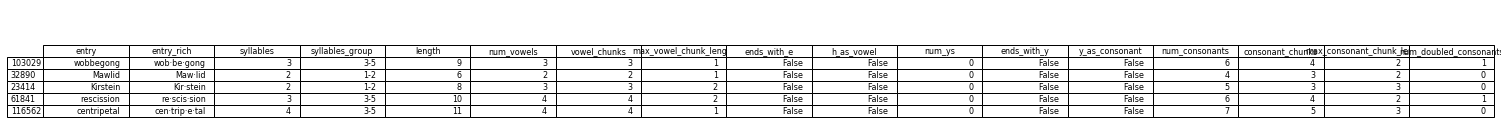

In [75]:
# https://stackoverflow.com/questions/44751045/save-pandas-table-filled-with-strings-as-png

fig, ax=plt.subplots(figsize=(26,.7))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)
tab = pd.plotting.table(ax=ax, data=df_words.sample(5), rowLabels=['']*5)
tab.auto_set_font_size(False)
tab.set_fontsize(8)
fig.savefig('words_sample.png', dpi=320)
plt.show()

# Modeling

## Separate train / validation / test datasets
## Create X features matrix and y target vector

In [76]:
df_words.columns

Index(['entry', 'entry_rich', 'syllables', 'syllables_group', 'length',
       'num_vowels', 'vowel_chunks', 'max_vowel_chunk_length', 'ends_with_e',
       'h_as_vowel', 'num_ys', 'ends_with_y', 'y_as_consonant',
       'num_consonants', 'consonant_chunks', 'max_consonant_chunk_length',
       'num_doubled_consonants'],
      dtype='object')

In [77]:
target = 'syllables'

features = ['length', 'num_vowels', 'vowel_chunks', 'max_vowel_chunk_length', 'ends_with_e', 'h_as_vowel',
            'num_ys', 'ends_with_y', 'y_as_consonant', 'num_consonants', 'consonant_chunks',
            'max_consonant_chunk_length', 'num_doubled_consonants']

train, df_test = train_test_split(df_words, test_size=0.2, random_state=random_state, stratify=df_words[target])
df_train, df_val = train_test_split(train, test_size=0.2, random_state=random_state, stratify=train[target])

X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

print('Training set shapes:', X_train.shape, y_train.shape)
print('Validation set shapes:', X_val.shape, y_val.shape)
print('Test set shapes:', X_test.shape, y_test.shape)

Training set shapes: (57008, 13) (57008,)
Validation set shapes: (14253, 13) (14253,)
Test set shapes: (17816, 13) (17816,)


## Begin with a baseline

Not using majority class as a baseline, because it is a multiclass classification problem with imbalanced classes.

In [78]:
my_value_counts(df_train, target)

,count,percentage
syllables,,
2,20440,0.358546
3,16834,0.295292
4,9520,0.166994
1,4918,0.086269
5,3854,0.067605
6,1070,0.018769
7,284,0.004982
8,67,0.001175
9,14,0.000246


Using the accuracy score of a shallow decision tree as the baseline metric.

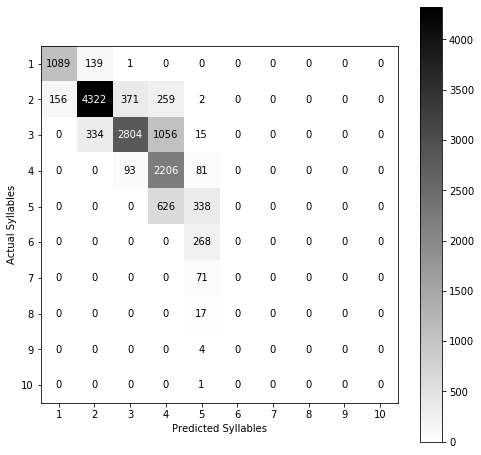

In [79]:
model_dt = DecisionTreeClassifier(
    max_depth=4, 
    random_state=random_state
).fit(X_train, y_train)

y_pred = model_dt.predict(X_val)
y_pred_proba = model_dt.predict_proba(X_val)

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(model_dt, X_val, y_val, values_format='.0f', cmap='binary', ax=ax)
plt.grid(False)
plt.xlabel('Predicted Syllables')
plt.ylabel('Actual Syllables')
plt.show()

In [80]:
baseline_cr = classification_report(y_val, y_pred, zero_division=0)
print(baseline_cr)

              precision    recall  f1-score   support

           1       0.87      0.89      0.88      1229
           2       0.90      0.85      0.87      5110
           3       0.86      0.67      0.75      4209
           4       0.53      0.93      0.68      2380
           5       0.42      0.35      0.38       964
           6       0.00      0.00      0.00       268
           7       0.00      0.00      0.00        71
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         1

    accuracy                           0.75     14253
   macro avg       0.36      0.37      0.36     14253
weighted avg       0.77      0.75      0.75     14253



In [81]:
baseline_accuracy = accuracy_score(y_val, y_pred)
baseline_roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovo')
print(f'Baseline accuracy: {baseline_accuracy * 100:.2f}%')
print(f'Baseline ROC/AUC: {baseline_roc_auc * 100:.2f}%')

Baseline accuracy: 75.49%
Baseline ROC/AUC: 81.73%


## Logistic Regression

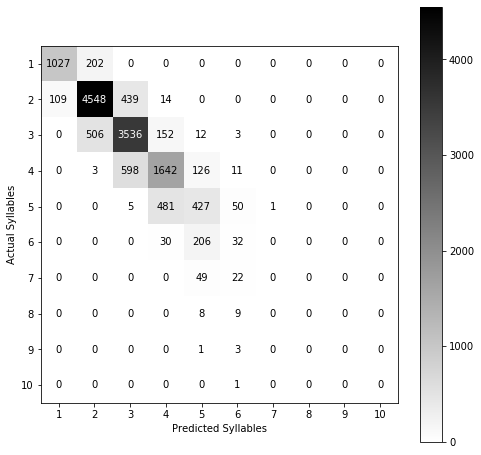

In [82]:
model_lr = LogisticRegression(    
    random_state=random_state, 
    n_jobs=-1
).fit(X_train, y_train)

y_pred = model_lr.predict(X_val)
y_pred_proba = model_lr.predict_proba(X_val)

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(model_lr, X_val, y_val, values_format='.0f', cmap='binary', ax=ax)
plt.grid(False)
plt.xlabel('Predicted Syllables')
plt.ylabel('Actual Syllables')
plt.show()

In [83]:
logreg_cr = classification_report(y_val, y_pred, zero_division=0)
print(logreg_cr)

              precision    recall  f1-score   support

           1       0.90      0.84      0.87      1229
           2       0.86      0.89      0.88      5110
           3       0.77      0.84      0.80      4209
           4       0.71      0.69      0.70      2380
           5       0.52      0.44      0.48       964
           6       0.24      0.12      0.16       268
           7       0.00      0.00      0.00        71
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         1

    accuracy                           0.79     14253
   macro avg       0.40      0.38      0.39     14253
weighted avg       0.77      0.79      0.78     14253



In [84]:
logreg_accuracy = accuracy_score(y_val, y_pred)
logreg_roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovo')
print(f'Logistic Regression validation accuracy: {logreg_accuracy * 100:.2f}%')
print(f'Logistic Regression validation ROC/AUC: {logreg_roc_auc*100:.2f}%')

Logistic Regression validation accuracy: 78.66%
Logistic Regression validation ROC/AUC: 62.64%


## Random Forest

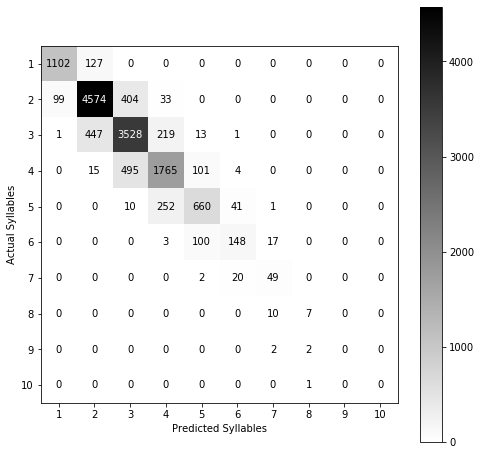

In [85]:
model_rf =  RandomForestClassifier(
    criterion = 'gini',
    max_depth = 100,
    max_features = 0.62,
    min_samples_leaf = 6,
    min_samples_split = 2,
    n_estimators = 135,
    random_state = random_state,
    n_jobs = -1
).fit(X_train, y_train)

y_pred = model_rf.predict(X_val)
y_pred_proba = model_rf.predict_proba(X_val)

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(model_rf, X_val, y_val, values_format='.0f', cmap='binary', ax=ax)
plt.grid(False)
plt.xlabel('Predicted Syllables')
plt.ylabel('Actual Syllables')
plt.show()

In [86]:
randomforest_cr = classification_report(y_val, y_pred, zero_division=0)
print(randomforest_cr)

              precision    recall  f1-score   support

           1       0.92      0.90      0.91      1229
           2       0.89      0.90      0.89      5110
           3       0.80      0.84      0.82      4209
           4       0.78      0.74      0.76      2380
           5       0.75      0.68      0.72       964
           6       0.69      0.55      0.61       268
           7       0.62      0.69      0.65        71
           8       0.70      0.41      0.52        17
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         1

    accuracy                           0.83     14253
   macro avg       0.61      0.57      0.59     14253
weighted avg       0.83      0.83      0.83     14253



In [87]:
randomforest_accuracy = accuracy_score(y_val, y_pred)
randomforest_roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovo')
print(f'Random Forest validation accuracy: {randomforest_accuracy * 100:.2f}%')
print(f'Random Forest validation ROC/AUC: {randomforest_roc_auc * 100:.2f}%')

Random Forest validation accuracy: 83.02%
Random Forest validation ROC/AUC: 95.82%


## Random Forest on test set

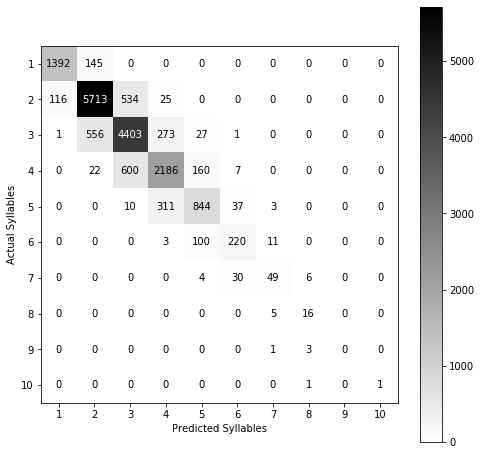

In [89]:
y_pred = model_rf.predict(X_test)
y_pred_proba = model_rf.predict_proba(X_test)

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(model_rf, X_test, y_test, values_format='.0f', cmap='binary', ax=ax)
plt.grid(False)
plt.xlabel('Predicted Syllables')
plt.ylabel('Actual Syllables')
plt.show()

In [90]:
randomforest_test_cr = classification_report(y_test, y_pred, zero_division=0)
print(randomforest_test_cr)

              precision    recall  f1-score   support

           1       0.92      0.91      0.91      1537
           2       0.89      0.89      0.89      6388
           3       0.79      0.84      0.81      5261
           4       0.78      0.73      0.76      2975
           5       0.74      0.70      0.72      1205
           6       0.75      0.66      0.70       334
           7       0.71      0.55      0.62        89
           8       0.62      0.76      0.68        21
           9       0.00      0.00      0.00         4
          10       1.00      0.50      0.67         2

    accuracy                           0.83     17816
   macro avg       0.72      0.65      0.68     17816
weighted avg       0.83      0.83      0.83     17816



In [91]:
randomforest_test_accuracy = accuracy_score(y_test, y_pred)
randomforest_test_roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
print(f'Random Forest test accuracy: {randomforest_test_accuracy * 100:.2f}%')
print(f'Random Forest Test ROC/AUC: {randomforest_test_roc_auc * 100:.2f}%')

Random Forest test accuracy: 83.21%
Random Forest Test ROC/AUC: 96.72%


# Create materials for dash app

# Index page linear teaser

In [92]:
px.scatter(df_words, x='length', y='syllables', trendline='ols', range_y=[0,10], range_x=[3, 20], opacity=.2, title='Word Length by Number of Syllables')

## Feature importances

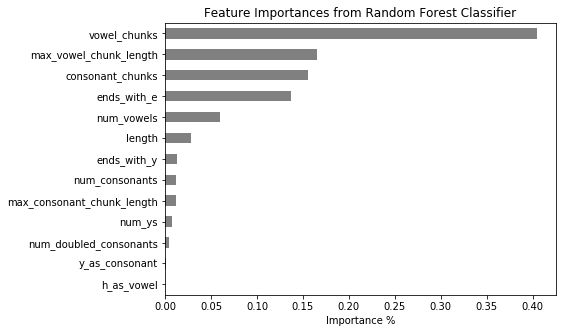

In [94]:
importances = pd.Series(model_rf.feature_importances_, features)

fig, ax = plt.subplots(figsize=(7,5))
importances.sort_values().plot.barh(color='grey', ax=ax)
plt.title('Feature Importances from Random Forest Classifier')
plt.xlabel('Importance %')
plt.show()

## Decision Tree visualization

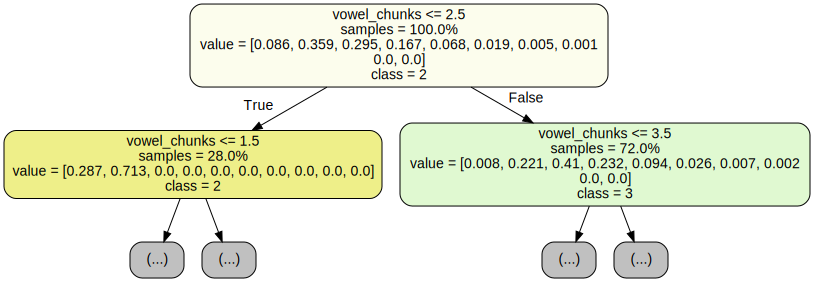

In [95]:
dt_vis = export_graphviz(
    decision_tree = model_dt, 
    max_depth=1, 
    feature_names=features,
    class_names = list(map(str, model_dt.classes_)),
    impurity = False,
    proportion = True,
    rounded = True,
    filled = True
)
display(graphviz.Source(dt_vis))

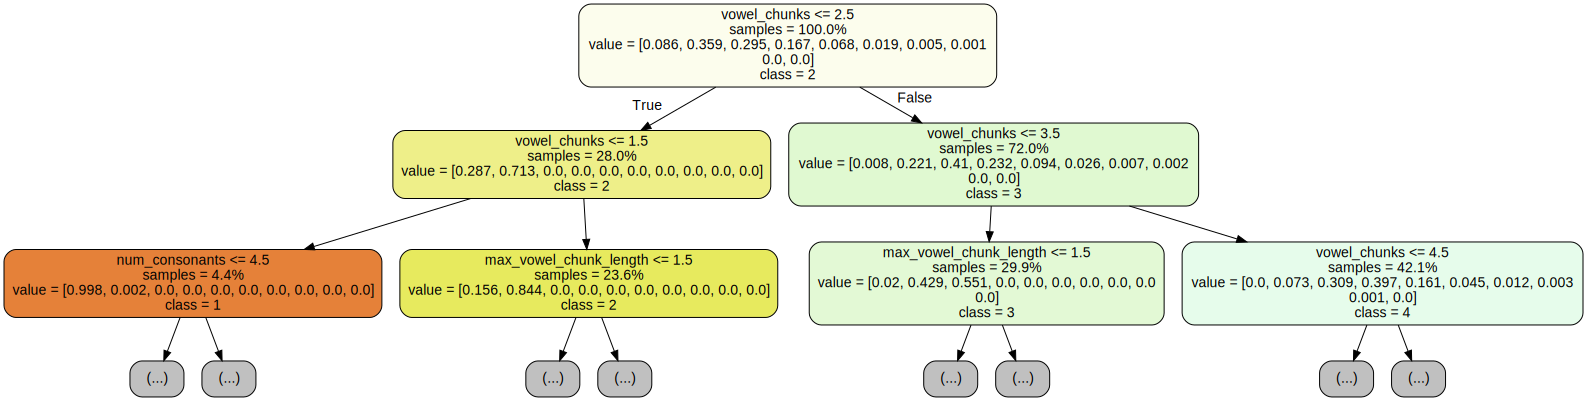

In [96]:
dt_vis_large = export_graphviz(
    decision_tree = model_dt, 
    max_depth=2, 
    feature_names=features,
    class_names = list(map(str, model_dt.classes_)),
    impurity = False,
    proportion = True,
    rounded = True,
    filled = True,
    # out_file = 'dt_vis_large.dot'
)

# graphviz.render(engine='dot', format='png', filepath='dt_vis_large.dot')

display(graphviz.Source(dt_vis_large))

## CSV of just words and syllables

Minimize the dataset for visualizations in the app.

In [0]:
df_words[['entry', 'syllables']].to_csv('words_min.csv', index=False)

## Pickled model

Serialize a final model using all the data for use in the predictions page.

In [98]:
X_pickle = df_words[features]
y_pickle = df_words[target]

pipeline_pickle = make_pipeline(
    RandomForestClassifier(
        criterion = 'gini',
        max_depth = 100,
        max_features = 0.62,
        min_samples_leaf = 6,
        min_samples_split = 2,
        n_estimators = 135,
        random_state = random_state,
        n_jobs = -1
    )
).fit(X_pickle, y_pickle)

dump(pipeline_pickle, 'pipeline.joblib', compress=True)

['pipeline.joblib']

Function to create features for arbitrary words for use in the model.

Will be adapted in the app as necessary.

In [99]:
# function to make a dataframe to predict an arbitrary word
def engineer_features(text:str):
  if text is None or text == '':
      return
  text = pd.Series(text)
  # replace anything that is not an english alphabetic character or white space with nothing
  # replace any white space sequences with the first white space character
  # split on whitespace into individual words
  words = pd.Series(text.str.replace('[^a-zA-Z\s]', '').str.replace('(\s)+', '\\1').str.split('\s')[0])
  words = words[words.str.len() > 0]
  if len(words) == 0 or words.str.len().sum() == 0:
      return
  data = {
      'length' : words.str.len(),
      'num_vowels' : words.str.lower().str.count('[aeiou]'),
      'vowel_chunks' : words.str.lower().str.count('[aeiou]+'),
      'max_vowel_chunk_length' : words.str.lower().str.split('[^aeiou]+').apply(lambda a_list : max([len(item) for item in a_list])),
      'ends_with_e' : words.str.lower().str.endswith('e'),
      'h_as_vowel' : words.str.lower().str.contains('[aeiou]h[^aeiouy]'),
      'num_ys' : words.str.lower().str.count('y'), 
      'ends_with_y' : words.str.lower().str.endswith('y'),
      'y_as_consonant' : words.str.lower().str.contains('[aeiou]y[aeiou]'),
      'num_consonants' : words.str.lower().str.count('[^aeiou]'), 
      'consonant_chunks' : words.str.lower().str.count('[^aeiou]+'),
      'max_consonant_chunk_length' : words.str.lower().str.split('[aeiou]+').apply(lambda a_list : max([len(item) for item in a_list])),
      'num_doubled_consonants' : words.str.lower().str.count('([^aeiou])\\1{1}[^$]')
  }
  df = pd.DataFrame(data)
  df.index = words
  display(df)
  y_pred = pipeline_pickle.predict(df)
  df_predictions = pd.DataFrame({
      'word' : words,
      'syllables' : y_pred
  })
  return df_predictions

engineer_features('Wonderful, this seemingly is functioning in a correct manner!!')

,length,num_vowels,vowel_chunks,max_vowel_chunk_length,ends_with_e,h_as_vowel,num_ys,ends_with_y,y_as_consonant,num_consonants,consonant_chunks,max_consonant_chunk_length,num_doubled_consonants
Wonderful,9,3,3,1,False,False,0,False,False,6,4,2,0
this,4,1,1,1,False,False,0,False,False,3,2,2,0
seemingly,9,3,2,2,False,False,1,True,False,6,3,4,0
is,2,1,1,1,False,False,0,False,False,1,1,1,0
functioning,11,4,3,2,False,False,0,False,False,7,4,3,0
in,2,1,1,1,False,False,0,False,False,1,1,1,0
a,1,1,1,1,False,False,0,False,False,0,0,0,0
correct,7,2,2,1,False,False,0,False,False,5,3,2,1
manner,6,2,2,1,False,False,0,False,False,4,3,2,1


,word,syllables
0,Wonderful,3
1,this,1
2,seemingly,2
3,is,1
4,functioning,3
5,in,1
6,a,1
7,correct,2
8,manner,2
